# Regression with PyTorch on Alvis
This will introduce the very basics of using PyTorch on Alvis.

As usual with Python the first step will be to load the necessary packages.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Constructing the data
In this step we generate a very simple dataset.

In [2]:
def f_true(x, slope=0.5, bias=0.3):
    '''The true underlying relation.'''
    return slope * x + bias

def get_data(n_points, noise_level=0.1, true_function=f_true, **tf_kwargs):
    '''Generates noisy data from true_function.
    Arguments:
        n_points (int): Number of datapoints to generate
        noise_level (float): Std of gaussian noise to be added
        true_function (callable): The noiseless underlying function
        **function_kwargs: Optional key-word arguments passed to true_function
    '''
    x = tf.random.uniform((n_points, 1), minval=-1, maxval=1)
    y = true_function(x, **tf_kwargs) + tf.random.normal((n_points, 1), stddev=noise_level)
    return x, y

In [3]:
x, y = get_data(300)

### Take a look at the data
As this is a notebook we can use the fact that we can easily take a look at graphical objects.

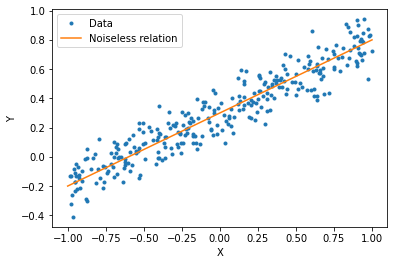

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(x, y, '.', label="Data")
x_plot = tf.linspace(-1, 1, 20)
plt.plot(x_plot, f_true(x_plot), label="Noiseless relation")
plt.xlabel("X")
plt.ylabel("Y")

plt.legend();

## Constructing the model

In TensorFlow 2.0 the two main ways to construct models is either through the Sequential API or the Functional API. The sequential API catches the most common use cases were all of the layers in your deep learning are handled sequentially, the functional API on the other hand can handle computational graphs that are a lot more complex.

In this example we will use the functional API even if the Sequential API would have been sufficient.

In [5]:
inputs = keras.Input(shape=(1,))
linear = layers.Dense(1)
outputs = linear(inputs)

# Instantiate the model
model = keras.Model(inputs=inputs, outputs=outputs, name="linear_model")
model.summary()


Model: "linear_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


Note that in this simple case, we could have simply done
```python
model = keras.Sequential(layers.Dense(1, input_shape=(1,)))
```
directly, but we will build on this simple model later.


## Training the model
Here we will use gradient descent to train our regression model on the data we have generated.

In [6]:
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.SGD(learning_rate=0.1, momentum=0.3),
)

history = model.fit(x, y, epochs=20, batch_size=x.shape[0])


Epoch 1/20
1/1 [==============================] - 1s 609ms/step - loss: 0.4898
Epoch 2/20
1/1 [==============================] - 0s 2ms/step - loss: 0.4071
Epoch 3/20
1/1 [==============================] - 0s 1ms/step - loss: 0.3225
Epoch 4/20
1/1 [==============================] - 0s 1ms/step - loss: 0.2552
Epoch 5/20
1/1 [==============================] - 0s 1ms/step - loss: 0.2041
Epoch 6/20
1/1 [==============================] - 0s 2ms/step - loss: 0.1650
Epoch 7/20
1/1 [==============================] - 0s 1ms/step - loss: 0.1346
Epoch 8/20
1/1 [==============================] - 0s 1ms/step - loss: 0.1106
Epoch 9/20
1/1 [==============================] - 0s 1ms/step - loss: 0.0913
Epoch 10/20
1/1 [==============================] - 0s 1ms/step - loss: 0.0758
Epoch 11/20
1/1 [==============================] - 0s 1ms/step - loss: 0.0633
Epoch 12/20
1/1 [==============================] - 0s 2ms/step - loss: 0.0532
Epoch 13/20
1/1 [==============================] - 0s 2ms/step - loss: 

## Evaluating the model
Here we generate new data that we can use to evaluate the model performance.

In [7]:
test_loss = model.evaluate(*get_data(100))

print(f"Test loss: {test_loss:.4g}")

4/4 [==============================] - 0s 989us/step - loss: 0.0176
Test loss: 0.01761


As a side note, if you are doing computations with tensors that you do not want to update during training you can use
```python
out_tensor = torch.stop_gradient(my_func(in_tensor))
```
or simply specify that they do not require gradients directly
```python
# For specific tensor
my_constant = tf.constant(value)
```

Compared to PyTorch `model(inputs)` does not by default compute the gradients as the backpropagation is handled by the fit method. If you want to handle this yourself you can check out [tensorflow.GradientTape](https://www.tensorflow.org/guide/autodiff).

### Visualising model predictions

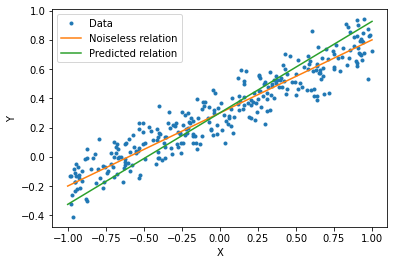

In [8]:
plt.figure()
plt.plot(x, y, '.', label="Data")
x_plot = tf.linspace(-1, 1, 20)
plt.plot(x_plot, f_true(x_plot), label="Noiseless relation")
plt.xlabel("X")
plt.ylabel("Y")

# Add model prediction
plt.plot(x_plot, model.predict(x_plot), label="Predicted relation")

plt.legend();


## Your own model
In TensorFlow 2 most use cases can be handled by the [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) or [Functional API](https://www.tensorflow.org/guide/keras/functional). This can then be extended by writing your own [custom layers](https://www.tensorflow.org/tutorials/customization/custom_layers), [custom losses](https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough) or [custom metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Metric).

### Excercises
1. Implement your own linear regression model with a fixed bias of 0.3, this can be done in several
different ways. Depending on your approach you might want to take a look at creating your own custom layer or use go very low level and you can subclass `tf.keras.Model` and use `tf.Variable` and `tf.constant`.

2. Train your model.

In [9]:
# Your code here
my_model = None


In [10]:
model.set_weights([(var + 1 * 10) for var in model.weights])
model.weights

[<tf.Variable 'dense/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[10.625873]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([10.300532], dtype=float32)>]

In [11]:
def check_model(model):
    if model is None:
        raise ValueError("Model is None.")
    x, y = get_data(1000)
    try:
        model(x)
    except Exception as e:
        print("Your model doesn't seem to handle input tensors of shape", x.size())
        raise e

    # Check bias
    bias_failure = False
    def check_bias(model):
        model_bias = model(tf.zeros((1, 1)))
        try:
            tf.debugging.assert_near(model_bias, tf.constant([[0.3]]))
        except tf.errors.InvalidArgumentError as e:
            nonlocal bias_failure
            bias_failure = True
            print(model.weights)
            print(f"Failure: The bias is {float(model_bias)}, not 0.3")
    check_bias(model)
    
    # Check that training changes the model performance
    if len(model.weights) != 1:
        print("Failure: Your model doesn't seem to only have a slope parameter.")
    
    # Check bias after training
    model_copy = tf.keras.models.clone_model(model)
    model_copy.set_weights([(var + 1) * 10 for var in model.weights])

    if not bias_failure:
        print("Checking model bias after changing variable values...")
        check_bias(model_copy)

In [12]:
check_model(my_model)

ValueError: Model is None.

## Running on a single GPU
For this example you will need access to a GPU, on Alvis there are four T4 GPUs
available on the login node, to see their status you can use the command
`nvidia-smi`. If they seem to be available then you can go ahead and use one of
them for the following excercises, otherwise you will have to submit a job.

If you are going to submit a job you can modify the `jobscript-tensorflow.sh`
file, if you have forgotten what to think about when constructing a job script
you can take a look at part 1 and/or the introduction slides.

Now for the actual coding. In TensorFlow GPU acceleration on a single GPU is
handled transparently with no code changes, an overview of this you can find
in the TF [GPU Guide](https://www.tensorflow.org/guide/gpu).

To make sure that your code runs on a GPU you can first check
```python
tf.config.list_physical_devices('GPU')
```
and for detailed information on all operations use
```python
import tensorflow as tf
tf.debugging.set_log_device_placement(True)
```
note that you'll have to do this at the very start of your code.

If you want to run on a specific device you can use
```
with tf.device("/GPU:0"):
    # Operations on GPU 0
```


### Excercises
1. Use `nvidia-smi` to find out about current GPU usage

In [13]:
%%bash
nvidia-smi

Thu Nov 11 11:54:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:3B:00.0 Off |                    0 |
| N/A   56C    P0    30W /  70W |  14224MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            On   | 00000000:5E:00.0 Off |                    0 |
| N/A   

2. Decide if you will do the following excercises on the log-in node or if you
will submit a job. Or both for the experience
3. Modify the below code to see if your training runs on GPU

In [14]:
# You should modify this block so that it runs on a GPU
# and later also change the amount of data to train on

x, y = get_data(300)

model = tf.keras.Sequential(
    layers.Dense(1),
)
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.SGD(learning_rate=0.1, momentum=0.3),
)

model.fit(x, y);

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]
10/10 [==============================] - 0s 952us/step - loss: 0.0435


4. When you think you've succeded submit it with the jobscript.sh
5. Use `sacct` in a terminal to find the job ID and then run `job_stats.py JOB_ID`
after substituting in the job ID. Look at the generated link.
6. Redo the GPU training but now do it with 1 billion data points. Compare the Grafana plots (that is, the page generated by `job_stats.py`)